# Previous models were trained on noisy datasets. 
A method was used to clean out mis-labelled data from these datasets. This notebook trains on cleaned data. 

In [100]:
description = "Train on cleaned data"

In [101]:
# !pip install wandb
# ! pip install wandb --upgrade

In [102]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [103]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [105]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [106]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, show_sample_from_df, clean_confidence_cats, get_recording_durations
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import glob

In [107]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"

# Log some hyperparameters

In [108]:
n_samples_per_class = 1700
one_output_neuron = False
random_seed = 43
learning_rate = 0.01
epochs=10

In [109]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [110]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

train_df.value_counts()

target_absence  target_presence
1.0             0.0                45081
0.0             1.0                 4211
Name: count, dtype: int64

In [111]:
cleaned_train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")

In [113]:
train_df = clean_confidence_cats(cleaned_train_df)
train_df["target_absence"] = 1-train_df["target_presence"]
train_df = train_df[["target_absence", "target_presence"]]
train_df.value_counts()

target_absence  target_presence
1.0             0.0                41770
0.0             1.0                 1784
Name: count, dtype: int64

# Remove invalid samples from invalid_samples.log

In [114]:
# read the contents of invalid_samples.log
with open("invalid_samples.log") as f:
    invalid_samples = f.readlines()
invalid_samples = [x.strip() for x in invalid_samples]
# convert to paths
invalid_samples = [Path(x) for x in invalid_samples]
# remove the invalid samples from the training set
train_df = train_df.drop(invalid_samples)


In [115]:
invalid_samples

[PosixPath('../../data/raw/recordings/OSFL/recording-104149.mp3')]

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [17]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

df6b00cc6ffa4efbaca189fa4093169c5ee439cbce5703f0454eed5da8081ed3 94fb8076aa519d619cea827bb16b859ae5e6463bb58f439815d99612bb3a30c4


AssertionError: Training set has changed

In [117]:
zero_len_recordings = [Path('../../data/raw/recordings/OSFL/recording-565606.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565607.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565618.flac')],
      

drop_df = train_df.loc[zero_len_recordings]
train_df.drop(drop_df.index, inplace=True)



In [118]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    41751
 1.0     1783
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [119]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    1700
 1.0    1700
 Name: count, dtype: int64,
 3400)

In [120]:
balanced_train_df.head()

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-556684... 4.5        7.5                  1.0   
../../data/raw/recordings/OSFL/recording-555557... 28.5       31.5                 1.0   
../../data/raw/recordings/OSFL/recording-552401... 129.0      132.0                1.0   
../../data/raw/recordings/OSFL/recording-566228... 43.5       46.5                 1.0   
../../data/raw/recordings/OSFL/recording-556625... 7.5        10.5                 1.0   

                                                                        target_presence  
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-556684... 4.5        7.5                   0.0  
../../data/raw/recordings/OSFL/recording-555557... 28.5       31.5                  0.0  
../../data/raw/recordings/OSFL/recording-552401... 129.0      132.0                 0.0  
../../data/raw/recordings/OSFL/recording-566228... 43.5       46.5                  0.0  
../../data/raw/recordings/OSFL/recording-556625... 7.5        10.5                  0.0

In [121]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [122]:
idx=0

In [123]:
shuffled_balanced_train_df = balanced_train_df.sample(frac=1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1)

Present label: 0.0
Last clip: 30.0


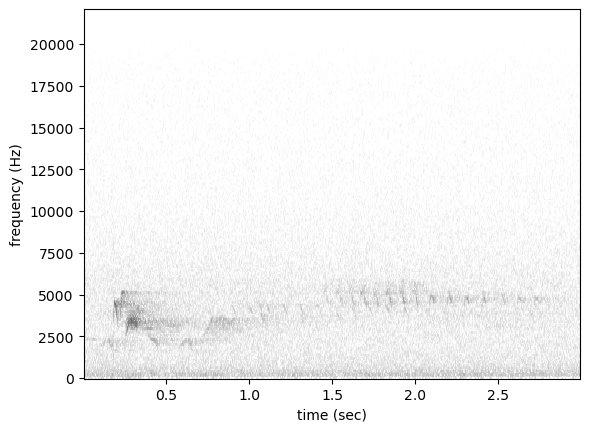

In [124]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [125]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_absence', 'target_presence'], dtype='object'),
 Index(['target_absence', 'target_presence', 'confidence_cat'], dtype='object'))

# Calculate recording durations for each recording in the training data
Some recordings might be corrupt and have zero samples. 

In [128]:
train_recording_durations = get_recording_durations(balanced_train_df)

getting_audio_file_durations: 100%|██████████| 3400/3400 [14:59<00:00,  3.78it/s]


In [134]:
balanced_train_df['recording_duration'] = train_recording_durations

In [138]:
balanced_train_df.loc[balanced_train_df['recording_duration'] < 3]

SyntaxError: invalid syntax (2136979514.py, line 1)

# Remove invalid samples printed during processing


In [129]:
def remove_files_from_df(df: pd.DataFrame, files: list):
    ''' 
    df must be a multi-indexed DataFrame with the first level being the file path.
    files is a list of string filepaths. 
    '''
    files = [Path(f) for f in files]
    df = df.drop(files)

In [ ]:
short_samples = [("../../data/raw/recordings/OSFL/recording-293782.mp3"),
("../../data/raw/recordings/OSFL/recording-294264.mp3"),
("../../data/raw/recordings/OSFL/recording-292726.mp3"),
("../../data/raw/recordings/OSFL/recording-300271.mp3"),
("../../data/raw/recordings/OSFL/recording-296664.mp3")]
short_samples = [Path(x) for x in short_samples]
train_df = train_df.drop(short_samples)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_84770/3083921300.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_df = train_df.drop(short_samples)


In [ ]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
    
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = True

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_absence', 'target_presence']

# Inspect the input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

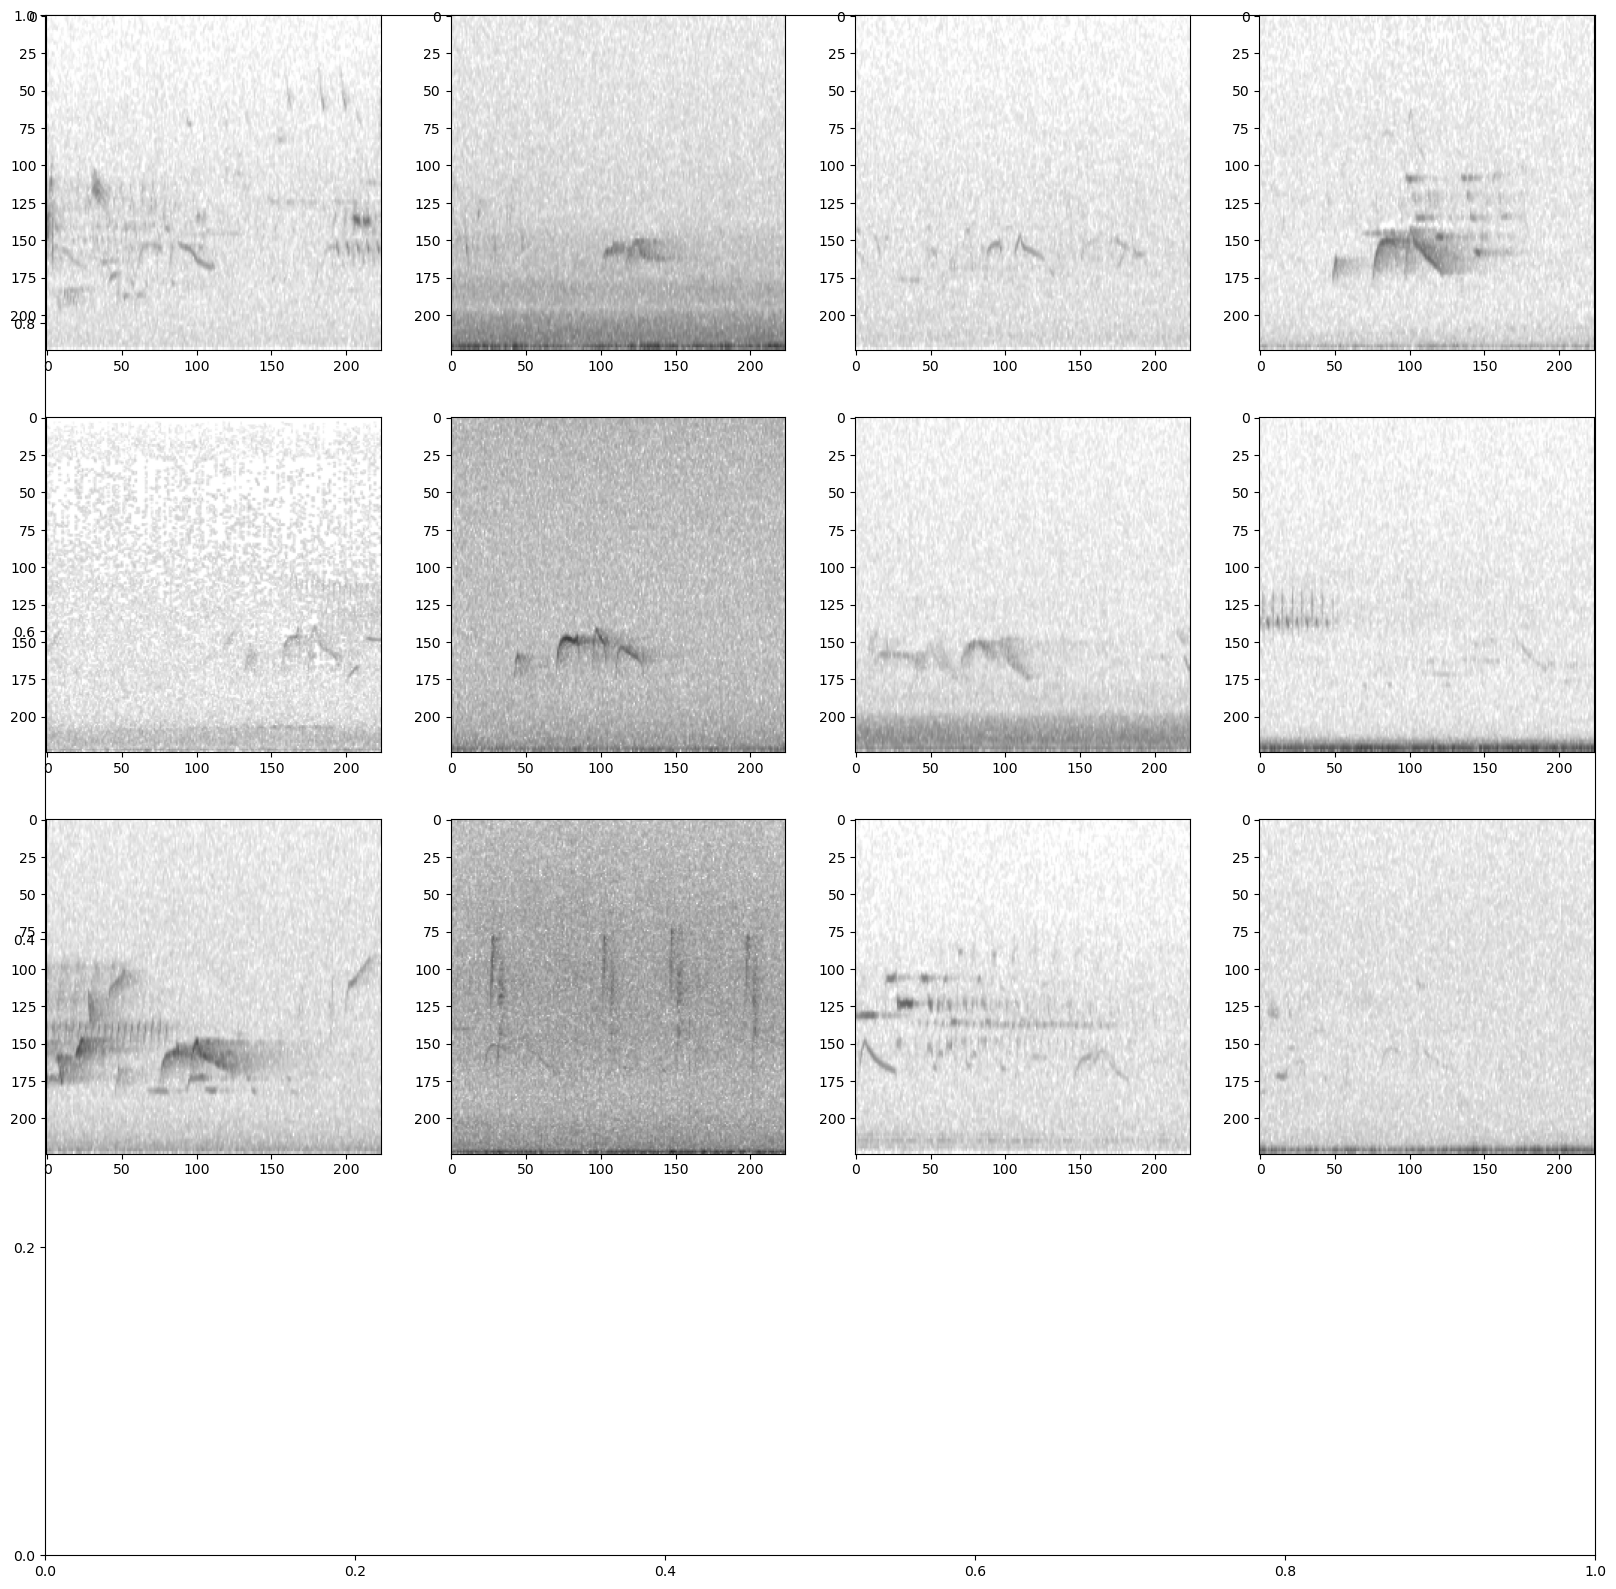

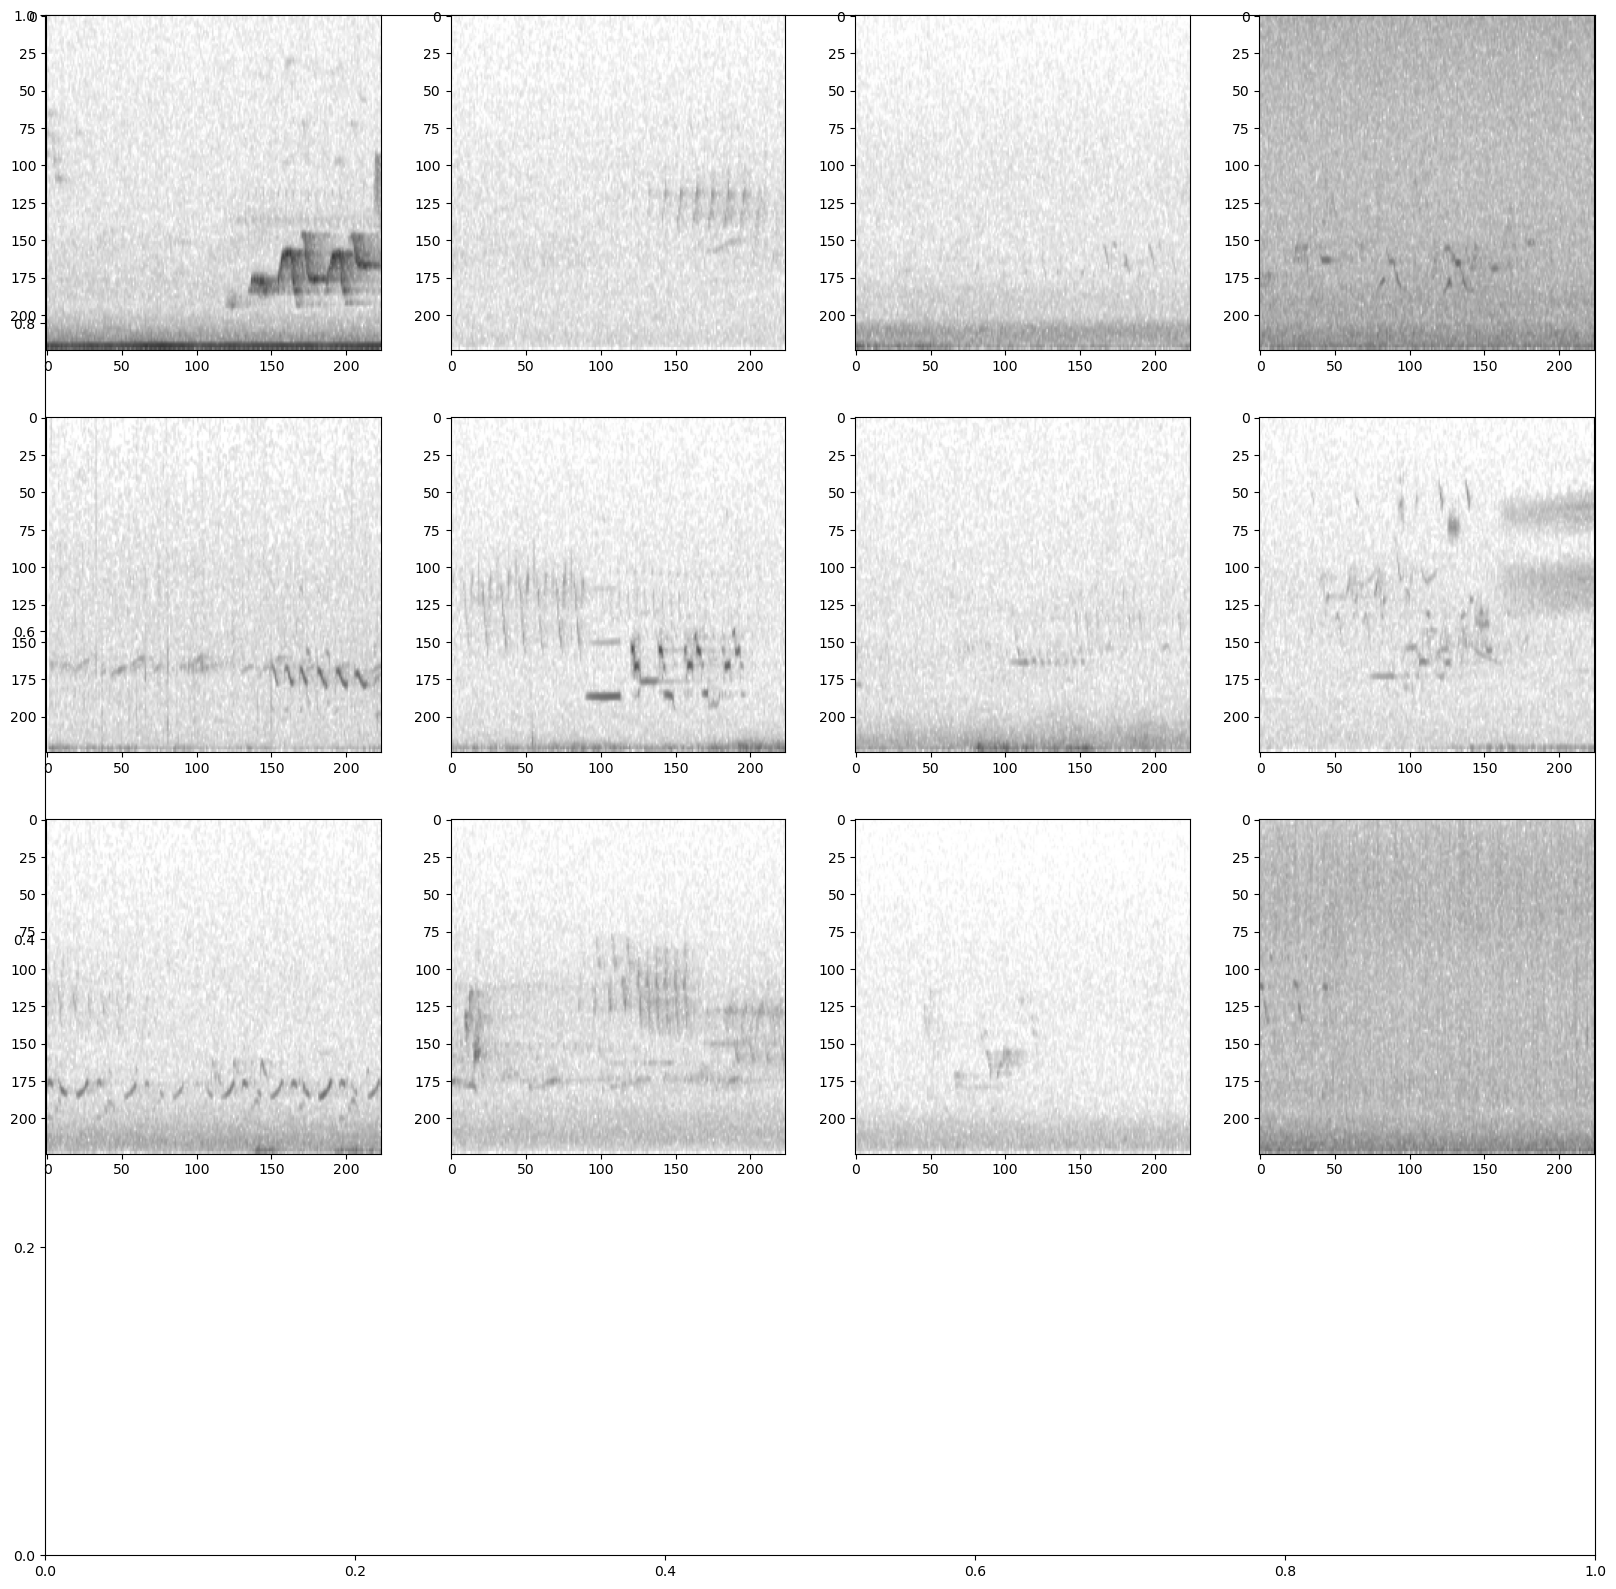

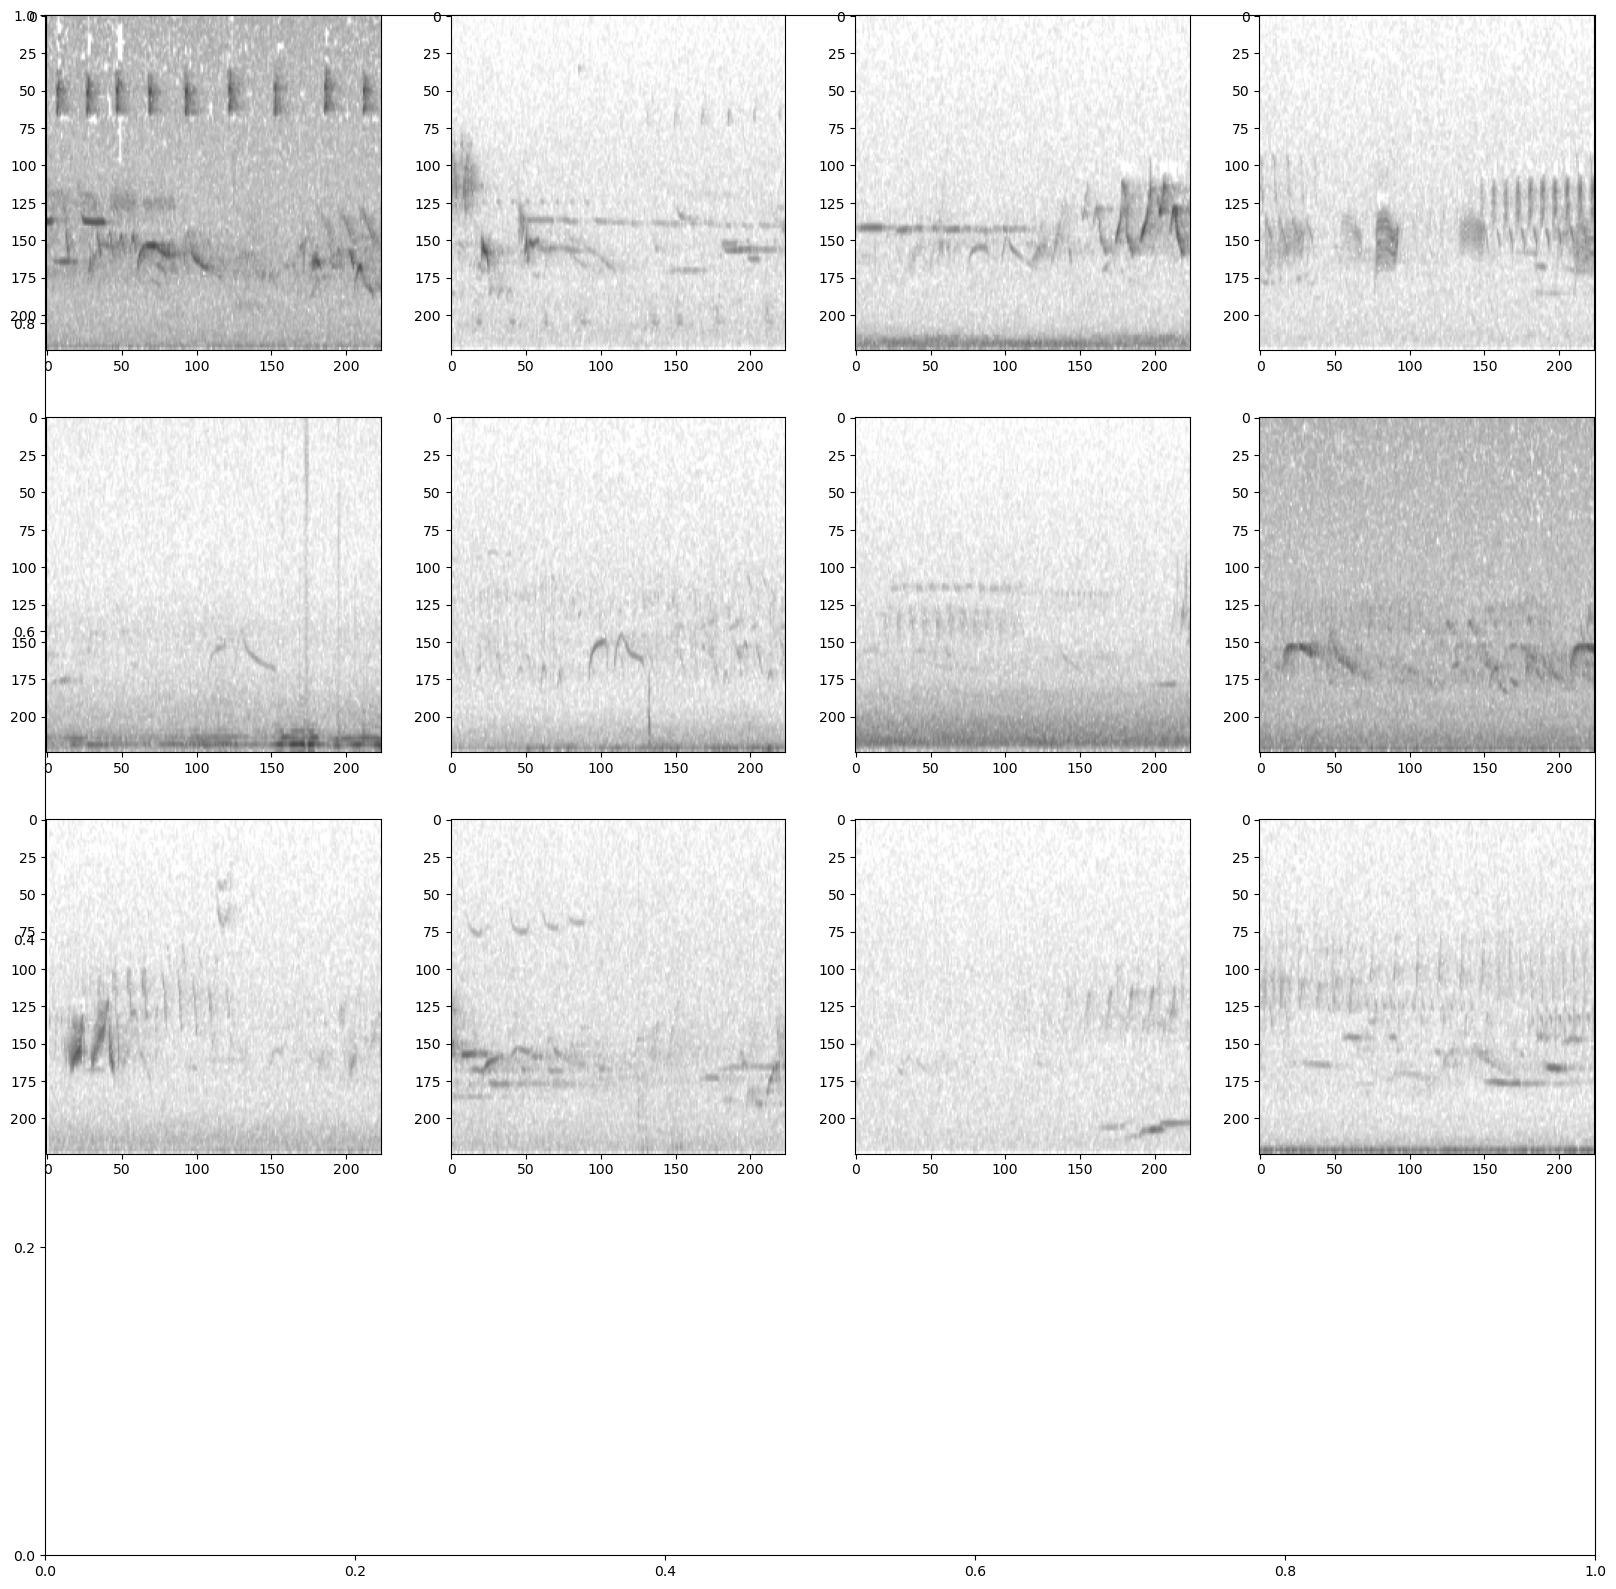

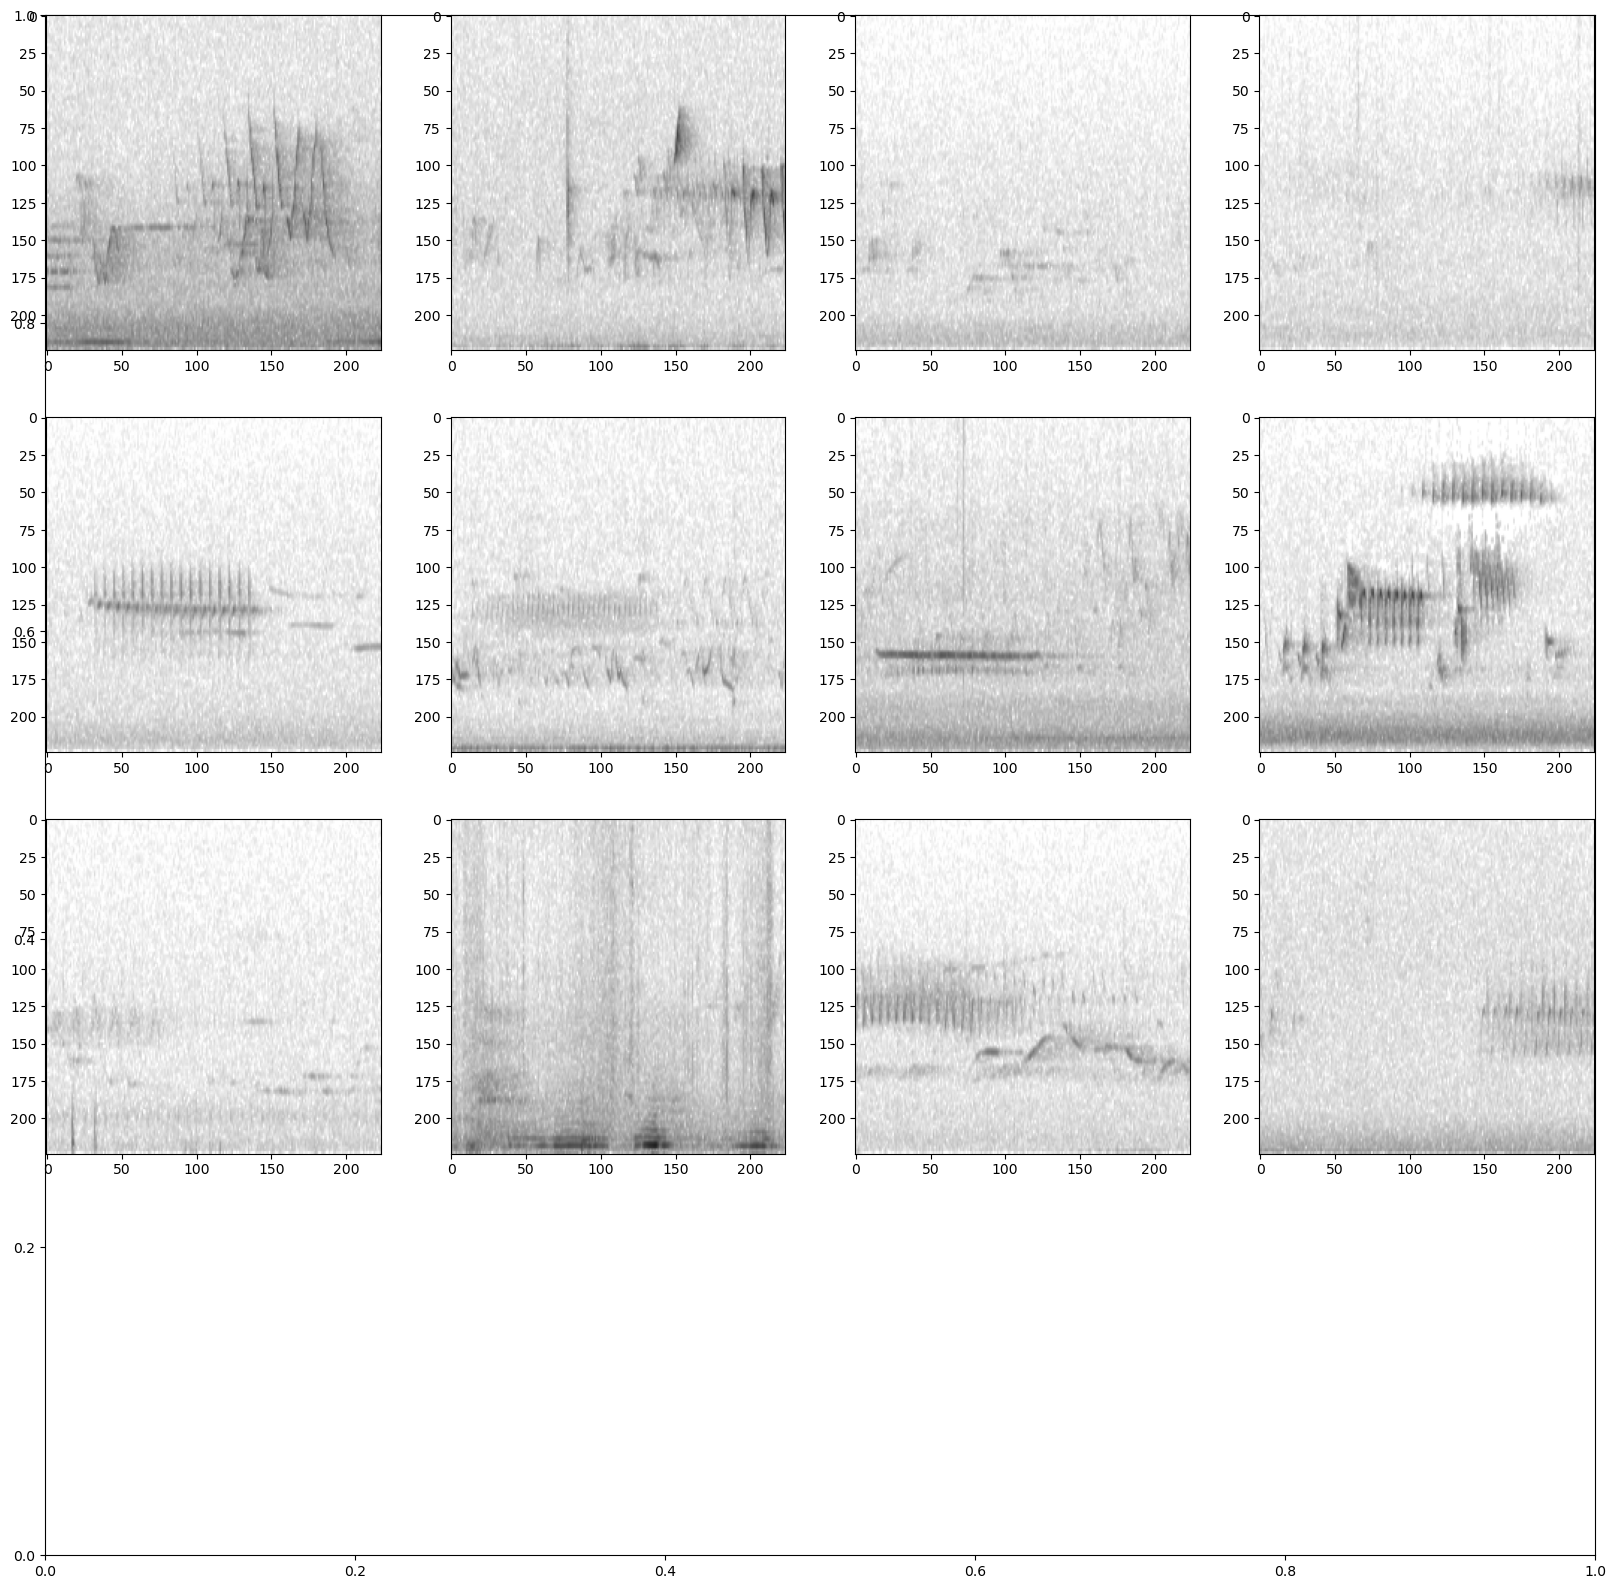

In [32]:
def inspect_input_samples(train, valid):
    present_t = train_df.loc[train_df.target_presence == 1]
    absent_t = train_df.loc[train_df.target_presence == 0]
    present_v = balanced_valid_df.loc[balanced_valid_df.target_presence == 1]
    absent_v = balanced_valid_df.loc[balanced_valid_df.target_presence == 0]

    #generate a dataset with the samples we wish to generate and the model's preprocessor
    for df in [present_t, absent_t, present_v, absent_v]:
        inspection_dataset = opso.AudioFileDataset(df.sample(12), model.preprocessor)
        inspection_dataset.bypass_augmentations = True

        samples = [sample.data for sample in inspection_dataset]
        _ = show_tensor_grid(samples,4,invert=True)

inspect_input_samples(shuffled_balanced_train_df, shuffled_balanced_valid_df)

# Check for leakage

In [33]:
train_files = shuffled_balanced_train_df.index.get_level_values("file")
valid_files = shuffled_balanced_valid_df.index.get_level_values("file")
assert train_files.isin(valid_files).sum() == 0, "Train and validation sets have overlapping files"

In [34]:
model.optimizer_params['lr'] = learning_rate

In [35]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [36]:
class_list

['target_absence', 'target_presence']

In [37]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


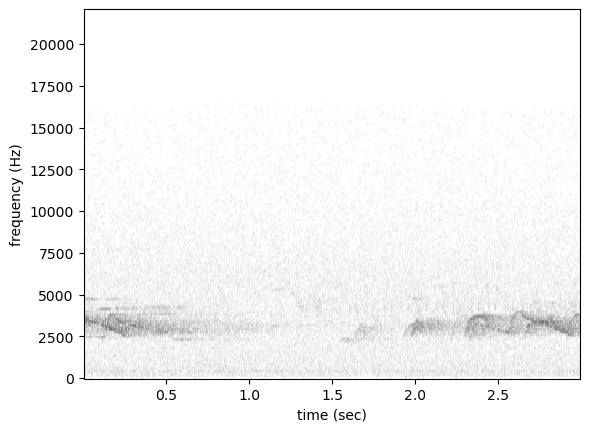

In [38]:
show_sample_from_df(present=True)


In [39]:
print(f'model.device is: {model.device}')

model.device is: mps


In [40]:
Path.cwd() / "1.15.1-mjg-osfl-revisit-opso-training-cycle.ipynb"

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.15.1-mjg-osfl-revisit-opso-training-cycle.ipynb')

In [41]:
%set_env WANDB_NOTEBOOK_NAME=({Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb"})

env: WANDB_NOTEBOOK_NAME=(/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb)


# Weights and biases initialization

In [42]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find (/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb).
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [43]:
shuffled_balanced_valid_df.value_counts(),
shuffled_balanced_train_df.value_counts()

target_absence  target_presence
0.0             1.0                1700
1.0             0.0                1700
Name: count, dtype: int64

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 2,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 10,
    save_interval = 1,
    invalid_samples_log='./invalid_training_samples.log',
    raise_errors=True,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 0 [batch 0/54, 0.00%] 
	DistLoss: 0.711
Metrics:
Epoch: 0 [batch 10/54, 18.52%] 
	DistLoss: 0.723
Metrics:
Epoch: 0 [batch 20/54, 37.04%] 
	DistLoss: 0.704
Metrics:
Epoch: 0 [batch 30/54, 55.56%] 
	DistLoss: 0.683
Metrics:
Epoch: 0 [batch 40/54, 74.07%] 
	DistLoss: 0.640
Metrics:
Epoch: 0 [batch 50/54, 92.59%] 
	DistLoss: 0.593
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 1


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 1 [batch 0/54, 0.00%] 
	DistLoss: 0.674
Metrics:
Epoch: 1 [batch 10/54, 18.52%] 
	DistLoss: 0.375
Metrics:
Epoch: 1 [batch 20/54, 37.04%] 
	DistLoss: 0.354
Metrics:
Epoch: 1 [batch 30/54, 55.56%] 
	DistLoss: 0.326
Metrics:
Epoch: 1 [batch 40/54, 74.07%] 
	DistLoss: 0.340
Metrics:
Epoch: 1 [batch 50/54, 92.59%] 
	DistLoss: 0.337
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 0 with Validation score 0.801.


In [47]:
model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 10,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 2


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 2 [batch 0/54, 0.00%] 
	DistLoss: 0.370
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 3


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 3 [batch 0/54, 0.00%] 
	DistLoss: 0.264
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 4


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 4 [batch 0/54, 0.00%] 
	DistLoss: 0.297
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 5


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 5 [batch 0/54, 0.00%] 
	DistLoss: 0.359
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 6


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 6 [batch 0/54, 0.00%] 
	DistLoss: 0.245
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 7


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 7 [batch 0/54, 0.00%] 
	DistLoss: 0.144
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 8


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 8 [batch 0/54, 0.00%] 
	DistLoss: 0.161
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 9


  0%|          | 0/54 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
model.valid_metrics

{0: {'confusion_matrix': array([[370, 130],
         [ 79, 421]]),
  'precision': 0.764065335753176,
  'recall': 0.842,
  'f1': 0.8011417697431017,
  'jaccard': 0.6536433917262933,
  'hamming_loss': 0.209},
 1: {'confusion_matrix': array([[466,  34],
         [161, 339]]),
  'precision': 0.9088471849865952,
  'recall': 0.678,
  'f1': 0.7766323024054983,
  'jaccard': 0.6699119481888185,
  'hamming_loss': 0.195},
 2: {'confusion_matrix': array([[456,  44],
         [105, 395]]),
  'precision': 0.8997722095671982,
  'recall': 0.79,
  'f1': 0.8413205537806175,
  'jaccard': 0.7399109747204666,
  'hamming_loss': 0.149},
 3: {'confusion_matrix': array([[490,  10],
         [191, 309]]),
  'precision': 0.9686520376175548,
  'recall': 0.618,
  'f1': 0.7545787545787546,
  'jaccard': 0.6574997871797055,
  'hamming_loss': 0.201},
 4: {'confusion_matrix': array([[449,  51],
         [ 88, 412]]),
  'precision': 0.8898488120950324,
  'recall': 0.824,
  'f1': 0.8556593977154725,
  'jaccard': 0.755668

In [49]:
model.train_metrics

{0: {'confusion_matrix': array([[1170,  530],
         [ 595, 1105]]),
  'precision': 0.6758409785932722,
  'recall': 0.65,
  'f1': 0.6626686656671664,
  'jaccard': 0.502659808317946,
  'hamming_loss': 0.33088235294117646},
 1: {'confusion_matrix': array([[1534,  166],
         [ 332, 1368]]),
  'precision': 0.8917861799217731,
  'recall': 0.8047058823529412,
  'f1': 0.8460111317254174,
  'jaccard': 0.7440201154518065,
  'hamming_loss': 0.14647058823529413},
 2: {'confusion_matrix': array([[1594,  106],
         [ 275, 1425]]),
  'precision': 0.9307642064010451,
  'recall': 0.8382352941176471,
  'f1': 0.8820798514391829,
  'jaccard': 0.7980625762227176,
  'hamming_loss': 0.11205882352941177},
 3: {'confusion_matrix': array([[1582,  118],
         [ 241, 1459]]),
  'precision': 0.9251743817374762,
  'recall': 0.8582352941176471,
  'f1': 0.890448581019225,
  'jaccard': 0.8087870224425844,
  'hamming_loss': 0.10558823529411765},
 4: {'confusion_matrix': array([[1580,  120],
         [ 255

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [179]:
wandb.run.name

'unique-breeze-155'

In [181]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
model.save(f"{wandb.run.name}{1700}")

In [ ]:
best_model.save(model_save_path / f"osfl_model_{dt}")

# Show metrics

In [ ]:
model.valid_metrics

{0: {'confusion_matrix': array([[ 14, 486],
         [  2, 498]]),
  'precision': 0.5060975609756098,
  'recall': 0.996,
  'f1': 0.6711590296495957,
  'jaccard': 0.26647972006497334,
  'hamming_loss': 0.488},
 1: {'confusion_matrix': array([[169, 331],
         [ 40, 460]]),
  'precision': 0.5815423514538559,
  'recall': 0.92,
  'f1': 0.7126258714175059,
  'jaccard': 0.43325645139724556,
  'hamming_loss': 0.371},
 2: {'confusion_matrix': array([[416,  84],
         [121, 379]]),
  'precision': 0.8185745140388769,
  'recall': 0.758,
  'f1': 0.7871235721703012,
  'jaccard': 0.6594299406613284,
  'hamming_loss': 0.205},
 3: {'confusion_matrix': array([[363, 137],
         [ 75, 425]]),
  'precision': 0.7562277580071174,
  'recall': 0.85,
  'f1': 0.8003766478342749,
  'jaccard': 0.6492471503651628,
  'hamming_loss': 0.212},
 4: {'confusion_matrix': array([[444,  56],
         [125, 375]]),
  'precision': 0.8700696055684455,
  'recall': 0.75,
  'f1': 0.8055853920515573,
  'jaccard': 0.69243

Here we can see how the opso resample operation leaves the dataframe sorted into classes, so suffling is a necessary next step. 

In [ ]:
pd.concat([balanced_train_df.tail(), balanced_train_df.head()])

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-555445... 3.0        6.0                  0.0   
../../data/raw/recordings/OSFL/recording-295707... 7.5        10.5                 0.0   
../../data/raw/recordings/OSFL/recording-104318... 123.0      126.0                0.0   
../../data/raw/recordings/OSFL/recording-292017... 1.5        4.5                  0.0   
../../data/raw/recordings/OSFL/recording-255454... 1.5        4.5                  0.0   
../../data/raw/recordings/OSFL/recording-294795... 25.5       28.5                 1.0   
../../data/raw/recordings/OSFL/recording-316188... 31.5       34.5                 1.0   
../../data/raw/recordings/OSFL/recording-291910... 19.5       22.5                 1.0   
../../data/raw/recordings/OSFL/recording-552598... 40.5       43.5                 1.0   
../../data/raw/recordings/OSFL/recording-817014... 40.5       43.5                 1.0   

                                                                        target_presence  
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-555445... 3.0        6.0                   1.0  
../../data/raw/recordings/OSFL/recording-295707... 7.5        10.5                  1.0  
../../data/raw/recordings/OSFL/recording-104318... 123.0      126.0                 1.0  
../../data/raw/recordings/OSFL/recording-292017... 1.5        4.5                   1.0  
../../data/raw/recordings/OSFL/recording-255454... 1.5        4.5                   1.0  
../../data/raw/recordings/OSFL/recording-294795... 25.5       28.5                  0.0  
../../data/raw/recordings/OSFL/recording-316188... 31.5       34.5                  0.0  
../../data/raw/recordings/OSFL/recording-291910... 19.5       22.5                  0.0  
../../data/raw/recordings/OSFL/recording-552598... 40.5       43.5                  0.0  
../../data/raw/recordings/OSFL/recording-817014... 40.5       43.5                  0.0

In [ ]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

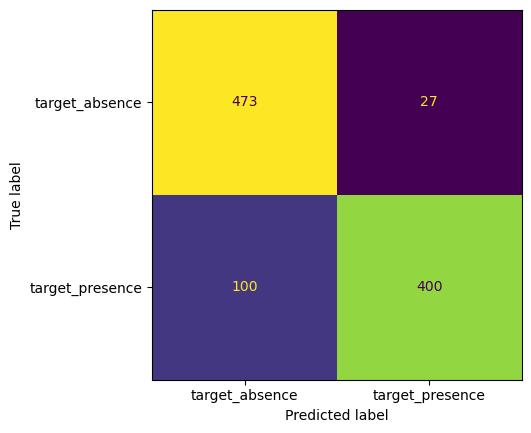

In [52]:
shuf_preds = model.predict(shuffled_balanced_valid_df)
opso.metrics.single_target_metrics(shuffled_balanced_valid_df, shuf_preds)
cm = opso.metrics.M.confusion_matrix(np.argmax(shuffled_balanced_valid_df, 1), (np.argmax(shuf_preds, 1)))

cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=model.classes)
cm_display.plot(colorbar=False)

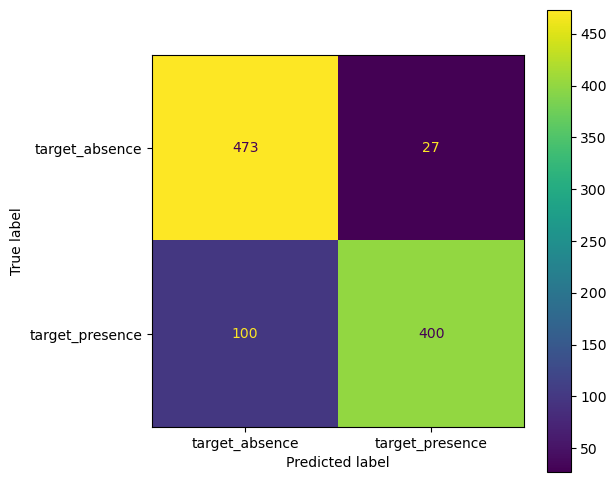

In [53]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax)
wandb.log({"Balanced classes confusion matrix": wandb.Image(fig)})

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

  0%|          | 0/10990 [00:00<?, ?it/s]

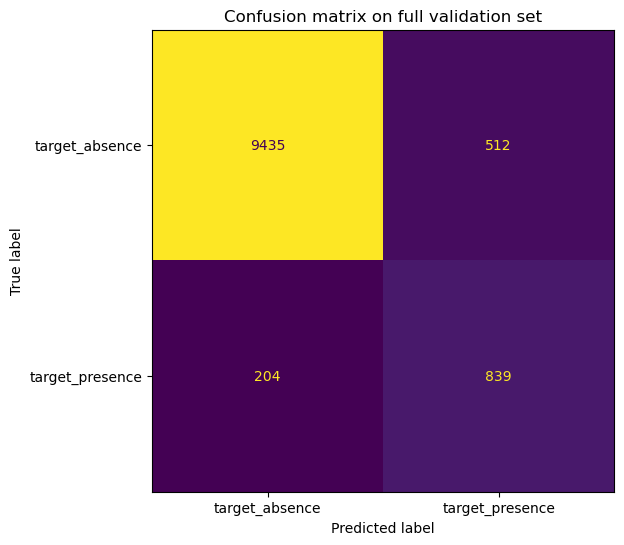

In [54]:
shuf_preds = model.predict(valid_df)
opso.metrics.single_target_metrics(valid_df, shuf_preds)
cm = opso.metrics.M.confusion_matrix(np.argmax(valid_df, 1), (np.argmax(shuf_preds, 1)))

cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=model.classes)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
# add a title
ax.set_title("Confusion matrix on full validation set")
cm_display.plot(ax=ax, colorbar=False)
wandb.log({"Confusion matrix on validation set with unbalanced classes": wandb.Image(fig)})


In [160]:
shuf_preds=shuf_preds[["target_absence", "target_presence"]]
shuf_preds

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0             0.233559   
                                                   1.5        4.5             5.634683   
                                                   3.0        6.0             2.967384   
                                                   4.5        7.5             6.025451   
                                                   6.0        9.0             5.147745   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0            4.362299   
                                                   34.5       37.5            1.545548   
                                                   36.0       39.0            5.550534   
                                                   37.5       40.5            4.867688   
                                                   40.5       43.5           -5.781662   

                                                                        target_presence  
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0             -0.213646  
                                                   1.5        4.5             -5.563867  
                                                   3.0        6.0             -2.880306  
                                                   4.5        7.5             -6.095166  
                                                   6.0        9.0             -5.212433  
...                                                                                 ...  
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0            -4.294681  
                                                   34.5       37.5            -1.481980  
                                                   36.0       39.0            -5.255339  
                                                   37.5       40.5            -4.782854  
                                                   40.5       43.5             5.858040  

[10990 rows x 2 columns]

In [161]:
predictions = np.argmax(shuf_preds, axis=1)

In [163]:
valid_df["preds"] = predictions
valid_df

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0                  1.0   
                                                   1.5        4.5                  1.0   
                                                   3.0        6.0                  1.0   
                                                   4.5        7.5                  1.0   
                                                   6.0        9.0                  1.0   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0                 1.0   
                                                   34.5       37.5                 1.0   
                                                   36.0       39.0                 1.0   
                                                   37.5       40.5                 1.0   
                                                   40.5       43.5                 0.0   

                                                                        target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0                   0.0   
                                                   1.5        4.5                   0.0   
                                                   3.0        6.0                   0.0   
                                                   4.5        7.5                   0.0   
                                                   6.0        9.0                   0.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0                  0.0   
                                                   34.5       37.5                  0.0   
                                                   36.0       39.0                  0.0   
                                                   37.5       40.5                  0.0   
                                                   40.5       43.5                  1.0   

                                                                        confidence_cat  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0                    0   
                                                   1.5        4.5                    0   
                                                   3.0        6.0                    0   
                                                   4.5        7.5                    0   
                                                   6.0        9.0                    0   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0                   0   
                                                   34.5       37.5                   0   
                                                   36.0       39.0                   0   
                                                   37.5       40.5                   0   
                                                   40.5       43.5                   2   

                                                                        preds  
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0           0  
                                                   1.5        4.5           0  
                                                   3.0        6.0           0  
                                                   4.5        7.5           0  
                                                   6.0        9.0 

In [168]:
# Drop rows where confidence cat of verified valid df is 1 or 2
verified_valid_df = valid_df[valid_df['confidence_cat'] != 1]
verified_valid_df = verified_valid_df[verified_valid_df['confidence_cat'] != 2]
verified_valid_df.confidence_cat.value_counts()

confidence_cat
0    9949
3     357
4      28
Name: count, dtype: int64

In [172]:
targets = verified_valid_df['target_presence'].astype(int).values
preds = verified_valid_df['preds'].astype(int).values
cm_v = opso.metrics.M.confusion_matrix(targets, preds, labels=[0, 1])
cm_v

array([[9435,  512],
       [   1,  386]])

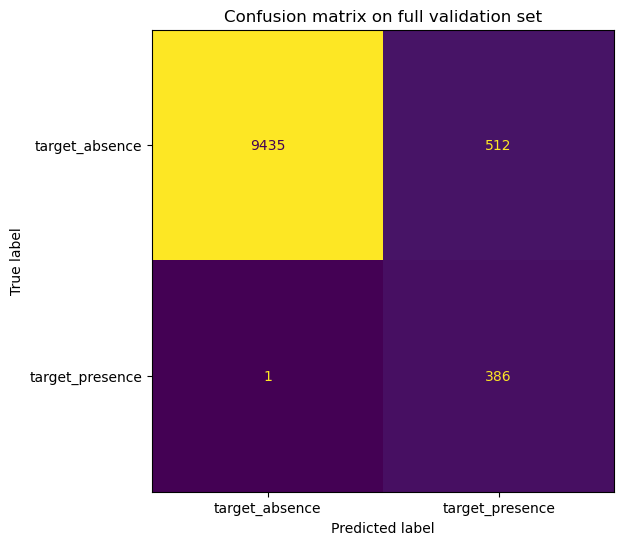

In [174]:
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm_v, display_labels=model.classes)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
# add a title
ax.set_title("Confusion matrix on full validation set")
cm_display.plot(ax=ax, colorbar=False)
wandb.log({"Confusion matrix on validation set with unbalanced classes": wandb.Image(fig)})


In [ ]:
balanced_train_df.sample()

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-538636... 6.0        9.0                  1.0   

                                                                        target_presence  
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-538636... 6.0        9.0                   0.0

In [ ]:
model.classes

['target_absence', 'target_presence']

In [ ]:
# wandb.finish()

# Result: 

This proves that the model can learn with absence at index 0. It was the shuffling of the training dataset which was preventing the model from learning. 

# Train the model further

In [ ]:
model.train(
    balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 10


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 [batch 0/25, 0.00%] 
	DistLoss: 0.179
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 11


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 [batch 0/25, 0.00%] 
	DistLoss: 0.363
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 12


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 [batch 0/25, 0.00%] 
	DistLoss: 0.338
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 13


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 [batch 0/25, 0.00%] 
	DistLoss: 0.218
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 14


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14 [batch 0/25, 0.00%] 
	DistLoss: 0.356
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 15


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 [batch 0/25, 0.00%] 
	DistLoss: 0.366
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 16


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16 [batch 0/25, 0.00%] 
	DistLoss: 0.293
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 17


  0%|          | 0/25 [00:00<?, ?it/s]

dyld[15215]: Assertion failed: (0), function deserialize, file ProcessAtlas.cpp, line 1981.



RuntimeError: DataLoader worker (pid(s) 15215) exited unexpectedly

In [ ]:
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_iter2_{dt}")

In [ ]:
# try training further on shuffled balanced train set
best_model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 4,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 15


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 [batch 0/25, 0.00%] 
	DistLoss: 0.338
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 16


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16 [batch 0/25, 0.00%] 
	DistLoss: 0.166
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 17


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17 [batch 0/25, 0.00%] 
	DistLoss: 0.345
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 18


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18 [batch 0/25, 0.00%] 
	DistLoss: 0.235
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 18 with Validation score 0.859.


In [ ]:
# Try training further on the shuffled training set
best_model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 6,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 19


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19 [batch 0/25, 0.00%] 
	DistLoss: 0.198
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 20 [batch 0/25, 0.00%] 
	DistLoss: 0.305
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 21


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21 [batch 0/25, 0.00%] 
	DistLoss: 0.137
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 22


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22 [batch 0/25, 0.00%] 
	DistLoss: 0.105
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 23


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23 [batch 0/25, 0.00%] 
	DistLoss: 0.171
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 24


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 24 [batch 0/25, 0.00%] 
	DistLoss: 0.098
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 19 with Validation score 0.857.


In [ ]:
best_model.valid_metrics

{0: {'confusion_matrix': array([[121, 379],
         [ 73, 427]]),
  'precision': 0.5297766749379652,
  'recall': 0.854,
  'f1': 0.6539050535987748,
  'jaccard': 0.3484742895603643,
  'hamming_loss': 0.452},
 1: {'confusion_matrix': array([[402,  98],
         [142, 358]]),
  'precision': 0.7850877192982456,
  'recall': 0.716,
  'f1': 0.7489539748953975,
  'jaccard': 0.6124152158284625,
  'hamming_loss': 0.24},
 2: {'confusion_matrix': array([[383, 117],
         [ 96, 404]]),
  'precision': 0.7754318618042226,
  'recall': 0.808,
  'f1': 0.7913809990205681,
  'jaccard': 0.6486993245080657,
  'hamming_loss': 0.213},
 3: {'confusion_matrix': array([[451,  49],
         [142, 358]]),
  'precision': 0.8796068796068796,
  'recall': 0.716,
  'f1': 0.7894156560088202,
  'jaccard': 0.6772934647532471,
  'hamming_loss': 0.191},
 4: {'confusion_matrix': array([[442,  58],
         [115, 385]]),
  'precision': 0.8690744920993227,
  'recall': 0.77,
  'f1': 0.816542948038176,
  'jaccard': 0.7043316

In [ ]:
# train for 10 more epochs with a lower learning rate
best_model.optimizer_params['lr']=0.001
best_model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 10,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 25


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25 [batch 0/25, 0.00%] 
	DistLoss: 0.227
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 26


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 26 [batch 0/25, 0.00%] 
	DistLoss: 0.203
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 27


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 27 [batch 0/25, 0.00%] 
	DistLoss: 0.221
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 28


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 28 [batch 0/25, 0.00%] 
	DistLoss: 0.199
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 29


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 29 [batch 0/25, 0.00%] 
	DistLoss: 0.157
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 30


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 30 [batch 0/25, 0.00%] 
	DistLoss: 0.101
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 31


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 31 [batch 0/25, 0.00%] 
	DistLoss: 0.153
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 32


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 32 [batch 0/25, 0.00%] 
	DistLoss: 0.143
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 33


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 33 [batch 0/25, 0.00%] 
	DistLoss: 0.141
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 34


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 34 [batch 0/25, 0.00%] 
	DistLoss: 0.133
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 32 with Validation score 0.872.


In [ ]:
predictions = best_model.predict(valid_df)
cm = opso.metrics.M.confusion_matrix(np.argmax(valid_df, 1), (np.argmax(predictions, 1)))

cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=best_model.classes)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
# add a title
ax.set_title("Confusion matrix on full validation set")
cm_display.plot(ax=ax, colorbar=False)


  0%|          | 0/10990 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute '_log'

In [ ]:
model = opso.cnn.load_model("best.model")
model.save(model_save_path / f"osfl_model_32_epoch{dt}")


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [ ]:

wandb.finish()


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore
